In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import statistics
import kmax as kx
import utility as util
from hierarchy import *
from scipy.optimize import fsolve
from IPython.core.debugger import set_trace

# Simulations

In [2]:
# CONSTANTS
LAM = 0.7

## GW Branching Process

For a Poisson branching process with $\lambda < 1$, we expect that
$$
\frac{X}{n}\underset{n\to\infty}{\longrightarrow}\frac{\mathbb{E}X}{\mathbb{E}N}
$$
where $X$ is the last-passage time of a GWBP tree with parameter $\lambda$

In theory,
$$
\mathbb{E}X = \frac{2-(\lambda p+2)e^{-\lambda p}}{1-\lambda}~~~~~\text{and}~~~~~\mathbb{E}N=\frac{1}{1-\lambda}
$$
where $p:=p(\lambda)$ is a solution to the equation $$pe^{\lambda p} = 1+\lambda p.$$

Thus
$$
\frac{\mathbb{E}X}{\mathbb{E}N} = 2-(\lambda p+2)e^{-\lambda p}.
$$
For example,
$
\lambda = 0.7 \implies p\approx 0.874161.
$

### Computation of $p,$ theoretical values

In [131]:
def solve_p(lam):
    func = lambda p: [p[0] * np.exp(lam*p[0]) - (1 + lam * p[0])]
    return float(fsolve(func, 0)[0])

In [132]:
p = solve_p(LAM)
EX_EN = 2-(2+LAM*p)*math.exp(-LAM*p)
EX = EX_EN / (1-LAM)

In [133]:
print(f'p = {p}')
print(f'EX/EN = {EX_EN}')
print(f'EX = {EX}')

p = 0.8741606425132245
EX/EN = 0.583526626641014
EX = 1.9450887554700462


### Approximation of $\frac{\mathbb{E}X}{\mathbb{E}N}$

We know $\mathbb{E}N=\frac{1}{1-\lambda}$ so we only need to compute $\mathbb{E}X$.

In [20]:
def iterate_GWBP_EX(num_samples=100):
    Xs = []
    for _ in range(num_samples):
        # Poisson Branching
        sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        # Get X for sample_tree
        _,_,X = util.path_cover(sample_tree, list(sample_tree.nodes())[0])
        Xs.append(X)
    return Xs

In [44]:
Xs = iterate_GWBP_EX(num_samples=10000)
EX_sampled = statistics.mean(Xs)
EX_sampled

1.9518

In [45]:
EX_EN_sampled = EX_sampled * (1 - LAM)
EX_EN_sampled

0.5855400000000001

In [42]:
#plt.hist(Xs, density=True, bins=100, range=(0,30))

$\%_{\text{error}}$ of sampled $\frac{\mathbb{E}X}{\mathbb{E}N}$ = 

In [46]:
(EX_EN_sampled - EX_EN) / EX_EN

0.01725126387658309

### Approximation of $\mathbb{E}(X/N)$
For each Galton Watson branching process look at the ratio of the X value and the size of the tree, generate multiple samples, look at their average. It will be different from expectation of X divided by expectation of N, but that should be the answer for the Erdos Renyi graph X/n

In [3]:
def iterate_GWBP_EX_N(num_samples=100):
    X_Ns = 0
    for _ in range(num_samples):
        # Poisson Branching
        sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        # Get X for sample_tree
        _,_,X = util.path_cover(sample_tree, list(sample_tree.nodes())[0])
            
        # Calculate X/N for current sample
        # GW Branching Process produces a single connected (tree) component, so N = |V|
        X_Ns += X / nx.number_of_nodes(sample_tree)
    return X_Ns / num_samples

In [4]:
EX_N_GWBP = iterate_GWBP_EX_N(num_samples=10000)
EX_N_GWBP

0.31389552362946316

## Erdos-Renyi Graphs $(G_{n,p})$

For Erdos-Renyi random graph $G\left(n,\frac{\lambda}{n}\right)$ compute the x value / n, for 1000 samples with n = 10000 or more. This should converge to E(X/N) where X =  x value for a Poisson(lam) branching process and N = number of nodes in the same Poisson(lam) branching process. X and N are correlated and we computed E(X), E(N) explicitly. What we need is E(X/N): this can be computed by simulation many Galton Watson Tree samples, for each sample compute X/N, take their average.

### Approximation of $\mathbb{E}(X/N)$

In [2]:
def X_sample_GNP(sample_tree):
    X = 0
    for nodes in nx.connected_components(sample_tree):
        subgraph = sample_tree.subgraph(nodes)
        path, _, Xi = util.path_cover(subgraph, list(nodes)[0])
        X += Xi
    return X

In [51]:
def iterate_GNP(num_samples=1000, n=10000):
    X_Ns = []
    for _ in range(num_samples):
        # Erdos-Reyni Graph
        sample_tree = nx.fast_gnp_random_graph(n, LAM/n)
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        # Calculate X/n for current sample
        X_Ns.append(X_sample_GNP(sample_tree) / n)
    return X_Ns

In [53]:
X_Ns = iterate_GNP()
EX_N_sampled = statistics.mean(X_Ns)
EX_N_sampled

0.3160146

Per Partha's above explanation, this value should converge to $\mathbb{E}(X/N)$ for a GWBP tree.

So let's examine the $\%_{\text{error}}$:

In [55]:
(EX_N_sampled - EX_N_GWBP) / EX_N_GWBP

0.01916320272448058

### Graphing

In [139]:
# https://stackoverflow.com/a/14000631
# Function for graphing an expression
def graph(formula, x_range, xlabel, ylabel):  
    x = np.array(x_range)
    y = formula(x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y, 'r')
    plt.show()

In [110]:
LAM = 0
lams = []
EXs = []
while LAM < 1:
    LAM += 0.01
    lams.append(LAM)
    EX = statistics.mean(iterate_GWBP_EX(num_samples=1000))
    EXs.append(EX)

Text(0, 0.5, 'EX (simulated)')

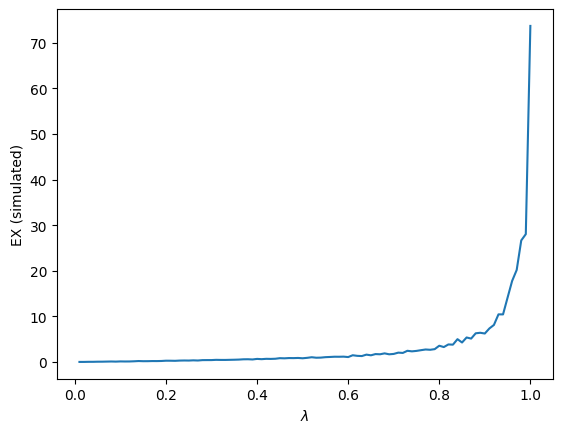

In [111]:
plt.plot(lams, EXs)
plt.xlabel("$\lambda$")
plt.ylabel("EX (simulated)")

In [140]:
func = lambda lam: (2-(lam*solve_p(lam)+2)*np.exp(-lam*solve_p(lam))) / (1-lam)
graph(func, np.arange(0.01,0.99,0.01),
      "$\lambda$", "EX (actual)")

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.